In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

from nltk.corpus import stopwords

import nltk

#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dylan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Metacritic Reviews

The Metacritic dataset originates from https://www.kaggle.com/skateddu/metacritic-critic-games-reviews-20112019 and was created by Andrea Cadeddu. It contains over 120,000 _individual reviews_ for many videogames, as well as the score each review gives each game. It will be used for text classification, particularly sentiment analysis of these reviews. I intend it as a more relevant-to-me alternative to the IMDB dataset as a sort of hello-world for sentiment analysis. Metacritic was chosen because it is a _meta_-review site; it compiles reviews published by other game journalism outlets.

In [6]:
metacritic = pd.read_csv("data/metacritic_critic_reviews.csv")

In [41]:
metacritic.sample(4)

,name,review,game,platform,score,date
123844,The Jimquisition,Nothing short of a mega patch will fix everyth...,We Happy Few,PC,NaN,"Aug 14, 2018"
64092,Everyeye.it,"It's a great twin stick shooter, one that deli...",Assault Android Cactus,PlayStation 4,80.0,"Mar 10, 2016"
41816,Gamer.no,Rise of the Dark Spark isn't completely hopele...,Transformers: Rise of the Dark Spark,PlayStation 4,40.0,"Jul 11, 2014"
15695,IGN,Deus Ex Human Revolution - Director’s Cut had ...,Deus Ex: Human Revolution - Director's Cut,Wii U,83.0,"Oct 21, 2013"


In [8]:
metacritic.isna().sum()
# Oh no, we have some reviewers that didn't score. Well, they'll be useless for training and testing, so I'm just going to drop them.
# as for those without dates... That information is still useful for analysis. So I'll drop those as well.

name           0
review         0
game           0
platform       0
score       1565
date          44
dtype: int64

In [9]:
metacritic.shape

(125876, 6)

In [90]:
def metacritic_clean(df):
    ret = df.dropna()
    
    ret['date'] = pd.to_datetime(ret['date'], errors='coerce')
    ret['year'] = pd.DatetimeIndex(ret['date']).year
    ret['month'] = pd.DatetimeIndex(ret['date']).month
    ret['day'] = pd.DatetimeIndex(ret['date']).day
    ret = ret.drop(['date', 'platform', 'game', 'name'], axis=1)
    
    # Let's convert scores into 'very low' through 'very high' for the sake of our own sanity.
    temp = pd.cut(ret['score'], bins=[0,20,40,60,80,100], include_lowest=True, labels=['very bad', 'bad', 'neutral', 'good', 'very good'])
    ret['score_coarse'] = pd.cut(ret['score'], bins=[0,33.3333,66.6666,100], include_lowest=True, labels=['bad', 'neutral', 'good'])
    ret['score'] = temp
    
    return ret

metacritic_cleaned = metacritic_clean(metacritic)

# The rest of this will have to be handled by the RNN

/home/dylan/.build/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dylan/.build/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/dylan/.build/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [99]:
df_train, df_test = train_test_split(metacritic_cleaned, test_size=0.2)

X_train = df_train.drop(['score', 'score_coarse'], axis=1)
y_train = df_train['score']
y_coarse = df_train['score_coarse']

X_train_text = X_train['review']

## tf-idf bag-of-words approach

In [43]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [45]:
cross_val_score(text_clf, X_train_text, y_train, cv=3, verbose=10, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  4.9min finished


array([0.55926731, 0.56382401, 0.56031023])

In [50]:
np.random.choice(tf.get_feature_names(), 20)

array(['wiser', 'apocalyptia', 'matters', 'pitiless', 'manliest', 'chose',
       'belligerent', 'hurdle', 'exam', 'gist', 'carefulprogress',
       'connors', 'front', 'sighs', 'aruban', 'wolverine', 'bang',
       'parting', 'education', 'golf'], dtype='<U26')

In [69]:
def get_tfidf_for_words(data):
    tfidf = TfidfVectorizer(min_df=3)
    tfidf.fit(data)
    feature_names = tfidf.get_feature_names()
    tfidf_matrix = tfidf.transform([' '.join(feature_names)]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    #return dict(tfidf_scores)
    return list(tfidf_scores)

wordscores = pd.DataFrame(get_tfidf_for_words(X_train_text), columns=['word', 'score'])

In [70]:
sortedwordscores = wordscores.sort_values('score')

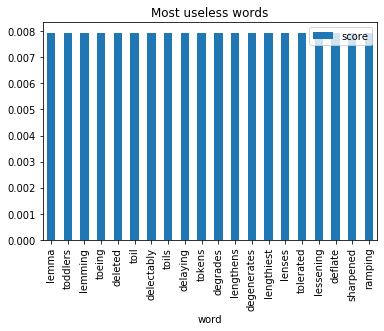

In [78]:
sortedwordscores.head(20).plot.bar(x='word', y='score', title='Most useless words')

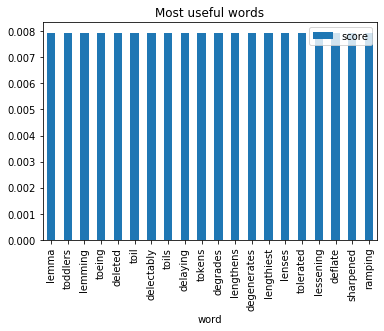

In [79]:
sortedwordscores.tail(20).plot.bar(x='word', y='score', title='Most useful words')

In [82]:
sortedwordscores.shape

(21241, 2)

Text(0, 0.5, 'Count')

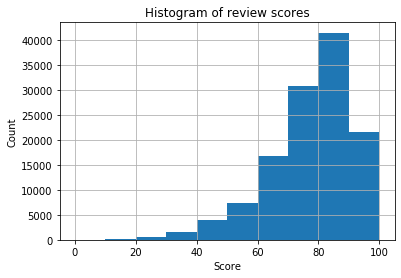

In [109]:
metacritic['score'].hist()
plt.title('Histogram of review scores')
plt.xlabel('Score')
plt.ylabel('Count')

In [85]:
for model in [RandomForestClassifier(), SVC(kernel='rbf', C=0.1, max_iter=10000)]:
    pipe = Pipeline([
        ('vect', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    print(cross_val_score(pipe, X_train_text, y_train, cv=3, verbose=10, n_jobs=4))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[0.56297906 0.56910496 0.56694933]
[0.51629549 0.53111232 0.49621269]


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 31.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 31.2min finished


In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

for model in [DecisionTreeClassifier(), KNeighborsClassifier()]:
    pipe = Pipeline([
        ('vect', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    print(cross_val_score(pipe, X_train_text, y_train, cv=3, verbose=10, n_jobs=4))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[0.45859738 0.45865773 0.45704198]
[0.49981894 0.47057758 0.49838549]


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.9min finished


Text(0, 0.5, 'Classification Accuracy')

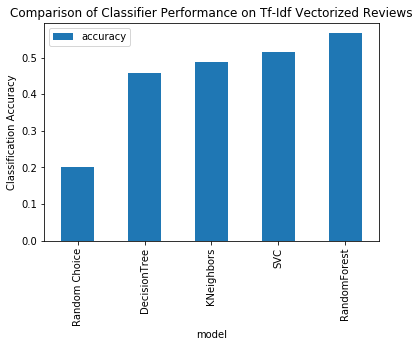

In [94]:
scores = pd.DataFrame({
    'model': ['Random Choice', 'DecisionTree', 'KNeighbors', 'SVC', 'RandomForest'],
    'accuracy': [0.2, np.mean([0.45859738, 0.45865773, 0.45704198]), np.mean([[0.49981894, 0.47057758, 0.49838549]]), np.mean([[0.51629549, 0.53111232, 0.49621269]]), np.mean([[0.56297906, 0.56910496, 0.56694933]])]
})
scores.plot.bar(x='model', y='accuracy', title='Comparison of Classifier Performance on Tf-Idf Vectorized Reviews')
plt.ylabel('Classification Accuracy')

In [100]:
scores_coarse = []
for model in [DecisionTreeClassifier(), KNeighborsClassifier(), RandomForestClassifier()]:
    pipe = Pipeline([
        ('vect', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    scores_coarse.append(cross_val_score(pipe, X_train_text, y_coarse, cv=3, verbose=10, n_jobs=4))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.8min finished


Text(0, 0.5, 'Coarse Classification Accuracy')

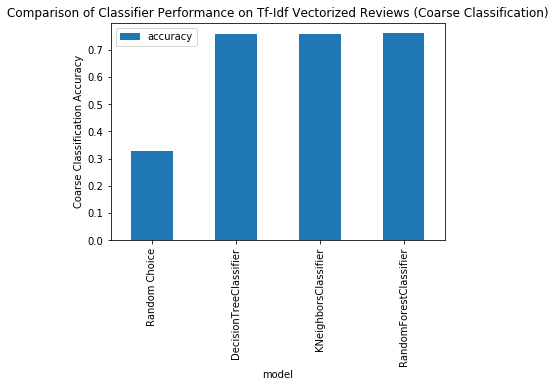

In [102]:
scores = pd.DataFrame({
    'model': ['Random Choice', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier'],
    'accuracy': [0.33] + list(np.mean(scores_coarse, axis=0))
})
scores.plot.bar(x='model', y='accuracy', title='Comparison of Classifier Performance on Tf-Idf Vectorized Reviews (Coarse Classification)')
plt.ylabel('Coarse Classification Accuracy')

In [103]:
scores_coarse

[array([0.71597562, 0.71663951, 0.71762682]),
 array([0.77014304, 0.76872473, 0.77834445]),
 array([0.78800773, 0.78855091, 0.78757884])]